# Load Data

In [6]:
%load_ext autoreload
%autoreload 2
from load import load_3D
from liftpose.vision_3d import XY_coord, Z_coord
import yaml
import logging
from imp import reload
import torch
import numpy as np
import matplotlib.pyplot as plt
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir' : "/data/LiftPose3D/fly_prism/data_oriented/training_data", # change the path 
       'out_dir'        : './out',
       "train_subjects": ["001", "002", "003"],
       'test_subjects'  : ["004"],
       'actions'        : ['PR']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# load data
train, train_keypts, _ = load_3D(par["data_dir"], subjects=par['train_subjects'], actions=par['actions'] )
test,  test_keypts, _ = load_3D( par["data_dir"], subjects=par['test_subjects'],  actions=par['actions'] )
#project data to ventral view
train_2d, train_3d = XY_coord(train), Z_coord(train)
test_2d, test_3d  = XY_coord(test), Z_coord(test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [7]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts, 
           **{k:par[k] for k in ['roots', 'target_sets', 'out_dir']})

[main.py:89]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/fly_prism/out/stat_2d.pth.tar.
[main.py:111]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/fly_prism/out/stat_3d.pth.tar.
[main.py:138]:INFO:Starting training model
[main.py:147]:DEBUG:
==================Options=================
[main.py:148]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 100000,
    'lr_gamma': 0.96,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:149]:DEBUG:=====================================

Epoch 0 | Loss Test 0 | Loss Train 1.3626|: 100%|██████████| 161/161 [00:02<00:00, 63.20it/s]
Epoch 1 | Loss Test 1.1432 | Loss Train 0.41372|: 100%|██████████| 161/161 [00:02<00:00, 66.14it/s]
Epoch 2 | Loss Test 0.80276 | Loss Train 0.14979|: 100%|██████████| 161/161 [00:02<00:00, 67.00it/s]
Epoch 3 | Loss Test 0.79826 | Loss Train 0.064748|: 100%|██████████| 161/161 [00:02<00:00, 67.74it/s]
Epoch 4 | Loss Test 0.78021 | Loss Train 0.040216|: 100%|██████████| 161/161 [00:02<00:00, 79.43it/s] 
Epoch 5 | Loss Test 0.69823 | Loss Train 0.032678|: 100%|██████████| 161/161 [00:02<00:00, 66.48it/s]
Epoch 6 | Loss Test 0.70934 | Loss Train 0.026733|: 100%|██████████| 161/161 [00:02<00:00, 64.47it/s]
Epoch 7 | Loss Test 0.6641 | Loss Train 0.024097|: 100%|██████████| 161/161 [00:02<00:00, 63.36it/s]
Epoch 8 | Loss Test 0.68012 | Loss Train 0.02372|: 100%|██████████| 161/161 [00:02<00:00, 68.02it/s] 
Epoch 9 | Loss Test 0.69889 | Loss Train 0.022618|: 100%|██████████| 161/161 [00:02<00:00, 68

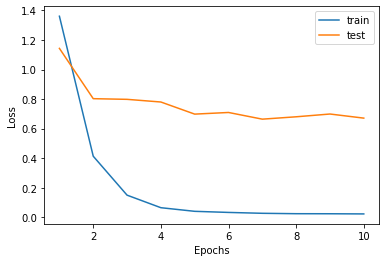

In [8]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [29]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:154]:INFO:starting testing in path: ./out
[lift.py:54]:INFO:total params: 4.28M
[lift.py:60]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:68]:INFO:ckpt loaded (epoch: 7 | err: 1.9928644895553589)
[lift.py:106]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/fly_prism/out/test_results.pth.tar


# Visualize Predictions

In [25]:
from liftpose.postprocess import load_test_results
data = torch.load(par['out_dir'] + "/test_results.pth.tar")
stat_2d, stat_3d = (
    torch.load(par['out_dir'] + "/stat_2d.pth.tar"),
    torch.load(par['out_dir'] + "/stat_3d.pth.tar"),
)
test_3d_gt, test_3d_pred = load_test_results(data, stat_2d, stat_3d)

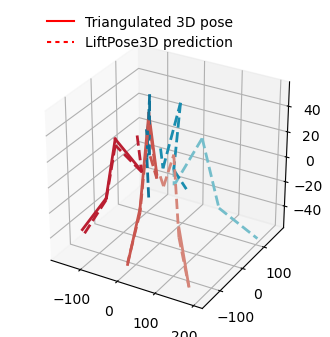

In [27]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
from liftpose.preprocess import add_roots
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=200, azim=60)

t = 1000
plot_pose_3d(ax, test_3d_gt[t],
            test_3d_pred[t], 
            par_data["vis"]["bones"], 
            par_data["vis"]["limb_id"], 
            par_data["vis"]["colors"],
            good_keypts=add_roots(data['good_keypts'], stat_3d["targets_3d"], len(stat_3d["mean"]))[t])